# 變異數分析

ANOVA 模型假設:
1. $E(\epsilon_{ij}) = 0$, 誤差期望值為 0
2. 同質變異數(homoscendasticity)假設: k 個處理內的變異數相等
3. 獨立性假設: $\epsilon_{ij}$ 誤差項與處理間相互獨立
4. 常態性假設: $\epsilon_{ij}$ 誤差項為常態分配


### One-way ANOVA CRD

以鳶尾花資料集為例，欲觀察不同的品種(處理)是否會影響花瓣長度(反應變數)，我們可以使用變異數分析來進行檢定。

- **H0: mu1 = mu2 = mu3,** 代表三個品種的花瓣長度沒有差異
- **H1: mu1 != mu2 != mu3**, 至少有一種花瓣的平均數和其他類別不相等

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df_iris = pd.read_csv('./datasets/iris.csv')
df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


<AxesSubplot: xlabel='Species', ylabel='PetalLengthCm'>

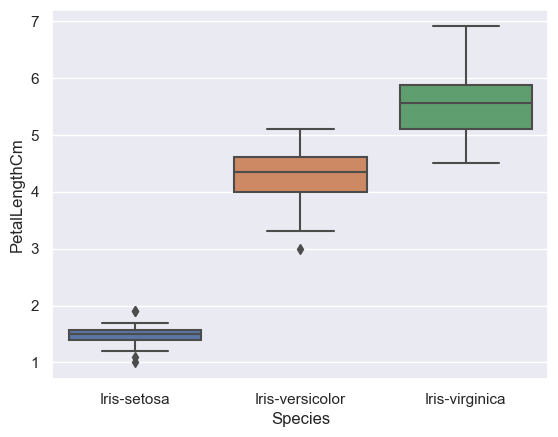

In [24]:
# 繪製箱形圖
sns.boxplot(x='Species', y='PetalLengthCm', data=df_iris)

In [74]:
# 計算不同類別(處理)之花瓣長度平均數
df_iris.groupby('Species')['PetalLengthCm'].mean()

Species
Iris-setosa        1.464
Iris-versicolor    4.260
Iris-virginica     5.552
Name: PetalLengthCm, dtype: float64

In [104]:
# 新增欄位紀錄不同類別鳶尾花的花瓣長度平均數, 用來計算組內組間變異
df_iris['mu_SpeciesPetalLength'] = df_iris.apply(lambda x: df_iris[df_iris['Species'] == x['Species']]['PetalLengthCm'].mean(), axis=1)

# 計算組間變異: 處理平方和(SSTR, Treatment Sum of Square) / 組間平方和(SSB, Sum of Squares Between)
mu_PetalLength = df_iris['PetalLengthCm'].mean()
squares_model = np.sum((df_iris['mu_SpeciesPetalLength'] - mu_PetalLength) ** 2)

print('花瓣長度平均值(Y_hat) =', mu_PetalLength, '\n')
print('組間變異平方和(SSTR, SSB) =', squares_model)

# 計算組內變異: 誤差平方和(SSE, Error of Sum of Squares) / 組內平方和(SSW, Sum of Squares Within)
# 需計算計算誤差 e = 
resid = df_iris['PetalLengthCm'] - df_iris['mu_SpeciesPetalLength']
squares_resid = np.sum(resid ** 2)
print('組內變異平方和(SSE, SSW) =', squares_resid)

# 總平方和(SSTO, Total Sum of Squares)
SSTO = sum((df_iris['PetalLengthCm'] - mu_PetalLength) ** 2)
print('總平方和(SSTO) =', SSTO)

# SSTO = SSTR + SSE
print('\nSSTO = SSTR + SSE =', squares_model + squares_resid)

花瓣長度平均值(Y_hat) = 3.758666666666666 

組間變異平方和(SSTR, SSB) = 436.64373333333333
組內變異平方和(SSE, SSW) = 27.220000000000002
總平方和(SSTO) = 463.86373333333336

SSTO = SSTR + SSE = 463.86373333333336


In [105]:
# 誤差期望值為零, 由於平均數只取到小數第三位, 計算上會有不為零的小數, 故在此四捨五入
print(round(resid.mean(), 4))

# 任意一個處理 setosa 誤差期望值為零
resid_setosa = df_iris[df_iris['Species']== 'Iris-setosa']['PetalLengthCm'] - df_iris[df_iris['Species']== 'Iris-setosa']['mu_SpeciesPetalLength']
print(round(resid_setosa.mean(), 4))

-0.0
0.0


In [122]:
# 處理(組間)平均平方(MSTR) = SSTR / (k-1); k 個處理自由度為 k-1
k = df_iris['Species'].nunique()
df_model = k - 1
variance_model = squares_model / df_model # MSTR
print('MSTR (MSB) =', variance_model)

# 誤差(組間)平均平方(MSE) = SSE / (n-k); n 誤差的自由度為 n-k
df_resid = len(df_iris) - k
variance_resid = squares_resid / df_resid # MSE
print('MSE (MSW) =', variance_resid)

# 檢定統計量 F = MSTR / MSE
f_ratio = variance_model / variance_resid
print('\nF Statistic =', f_ratio)

MSTR (MSB) = 218.32186666666666
MSE (MSW) = 0.1851700680272109

F Statistic = 1179.0343277002203


- F 檢定一律為右尾拒絕
- 臨界值法: 由於檢定統計量 F 大於臨界值, 故我們可拒絕掉虛無假說 H0, 鳶尾花花瓣長度在統計上存在顯著差異
- P-Value 法: 若 P-Value 小於顯著 0.05, 拒絕掉虛無假說 H0, 鳶尾花花瓣長度在統計上存在顯著差異

In [168]:
# 臨界值法, 判斷 F 是否大於臨界值位於拒絕域

critical_f = stats.f.isf(q=0.05, dfn=df_model , dfd=df_resid) # Percent point function: F_aplha
# stats.f.ppf(q=0.95, dfn=df_model, dfd=df_resid) # Inverse survival function: F_(1-alpha), 計算結果相同

print('在 Alpha = 0.05 , df1 =', df_model, ', df2 =', df_resid, '的條件下, F 分配的臨界值 =', critical_f)

在 Alpha = 0.05 , df1 = 2 , df2 = 147 的條件下, F 分配的臨界值 = 3.057620651649394


In [176]:
# P-Value 法檢定
pvalue = 1 - stats.f.cdf(x=f_ratio, dfn=df_model, dfd=df_resid)
print('P-Value =', pvalue)

significant_level = 0.05

if pvalue < significant_level:
    print('由於 P-Value 小於顯著水準', significant_level, ', 拒絕掉虛無假說 H0, 鳶尾花花瓣長度在統計上存在顯著差異')

P-Value = 1.1102230246251565e-16
由於 P-Value 小於顯著水準 0.05 , 拒絕掉虛無假說 H0, 鳶尾花花瓣長度在統計上存在顯著差異


快速解：使用 `scipy.stats` 套件進行 ANOVA F 檢定

In [135]:
# stats.f_oneway; 如果 P-Value < 顯著水準, 代表統計上可拒絕 H0
treatment_1 = df_iris.loc[df_iris['Species'] == 'Iris-setosa', 'PetalLengthCm']
treatment_2 = df_iris.loc[df_iris['Species'] == 'Iris-versicolor', 'PetalLengthCm']
treatment_3 = df_iris.loc[df_iris['Species'] == 'Iris-virginica', 'PetalLengthCm']

stats.f_oneway(treatment_1, treatment_2, treatment_3)

F_onewayResult(statistic=1179.0343277002194, pvalue=3.0519758018278374e-91)

快速解：使用 `statsmodels` 套件快速建立 ANOVA Table

In [179]:
anova_model = smf.ols("PetalLengthCm ~ Species", data=df_iris).fit()

print(sm.stats.anova_lm(anova_model, typ=2))

              sum_sq     df            F        PR(>F)
Species   436.643733    2.0  1179.034328  3.051976e-91
Residual   27.220000  147.0          NaN           NaN


In [182]:
# 花瓣長度 ~ N(Intercept + Species[T.Iris-versicolor] * 是否為 Iris-versicolor  + Species[T.Iris-virginica] * 是否為 virginica)
anova_model.params

Intercept                     1.464
Species[T.Iris-versicolor]    2.796
Species[T.Iris-virginica]     4.088
dtype: float64